# Analyze network balance with frustration index an algebraic conflict

In [2]:
import networkx as nx
import pandas as pd
from matplotlib import pyplot as plt
import tqdm
import os
from tqdm import tqdm
import glob
import re

import sys
sys.path.append('../local/bin/')

from sygno.signed_networkx import draw_signed_networkx

____________________

In [3]:
dataset_folder = '../dataset/'

Load the dataframe created in the *data_parsing.ipynb* containing all the information about the members of the congresses

In [4]:
pol = pd.read_csv(dataset_folder + 'members.csv')
pol['color'] = pol['party_name'].apply(lambda x: 'firebrick' if 'Republican' in x else ('royalblue' if 'Democrat' in x else 'yellow'))
pol.head()

,icpsr,congress,party_code,bioname,state_abbrev,party_name,color
0,1,[82],[200],"AANDAHL, Fred George",ND,['Republican'],firebrick
1,2,"[80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 9...",[100],"ABBITT, Watkins Moorman",VA,['Democrat'],royalblue
2,3,"[28, 29, 30]",[29],"ABBOTT, Amos",MA,['Whig'],yellow
3,4,"[50, 51, 52, 53, 54]",[100],"ABBOTT, Jo (Joseph)",TX,['Democrat'],royalblue
4,5,"[15, 16, 17, 18]","[7777, 13]","ABBOT, Joel",GA,"['Crawford Republican', 'Democrat-Republican']",firebrick


Create a dictionary that links each icpsr to a party. Notice that an icpsr identifies uniquely a legislator, but a legislator can have more than one icpsr. This is because the icpsr is assigned to a legislator for each congress. For example, if a legislator is elected in 2000 and reelected in 2002, he will have two different icpsr, one for each congress. We will use the icpsr of the first congress in which the legislator was elected.

In [5]:
pol_dic = pol[['icpsr', 'party_name']].set_index('icpsr').to_dict(orient="index")
# e.g.
pol_dic[323]

{'party_name': "['Democrat-Republican']"}

In [17]:
def draw_graph(df, pol_dic):

    # Arguments:
	# df ---> edgelist
	# pol_dic ---> dictionary where key is icpsr and value is party_name
	# congress_num ---> congress number

    G = nx.from_pandas_edgelist(df, 'source', 'target', ['weight'])

    nodeData = {list(g.icpsr)[0]: {'state': list(g.state_abbrev)[0], 'party': list(g.party_name)[0], 'color': list(g.color)[0],  'congress': list(g.congress)[0], 'name': list(g.bioname)[0]} for k, g in pol.groupby('icpsr')}
    nx.set_node_attributes(G, nodeData)

    colors = [node[1]['color'] for node in G.nodes(data=True)]
    
    fig, ax, pos, least_eigenvalue = draw_signed_networkx(G, node_color=colors, compact = True, theme="white", normalize=True, scale='log', jittering=0.01, margin=0.2, show_rotation=False, highlight_edges='frustrated', remove_n_outliers=3, sort_by='party')
    
    # print infos about users per party
    positions_party = {'pos': {'Democrat': 0,'Republican':0}, 'neg': {'Democrat': 0,'Republican':0}}
    for p in pos.keys():
        if pos[p].x > 0:
            if pol_dic[int(p)]['party_name'] == 'Democrat' or pol_dic[int(p)]['party_name'] == 'Republican':
                positions_party['pos'][pol_dic[int(p)]['party_name']] += 1
        else:
            if pol_dic[int(p)]['party_name'] == 'party_name' or pol_dic[int(p)]['party_name'] == 'Republican':
                positions_party['neg'][pol_dic[int(p)]['party_name']] += 1

    plt.text(0, .04, "Rep: "+str(positions_party['neg']['Republican']), fontsize=13, transform=ax.transAxes, color="ghostwhite")
    plt.text(0, .09, "Dem: "+str(positions_party['neg']['Democrat']), fontsize=13, transform=ax.transAxes, color="ghostwhite")

    plt.text(0.9, .04, "Rep: "+str(positions_party['pos']['Republican']), fontsize=13, transform=ax.transAxes, color="ghostwhite")
    plt.text(0.9, .09, "Dem: "+str(positions_party['pos']['Democrat']), fontsize=13, transform=ax.transAxes, color="ghostwhite")
    

    plt.show()

    return least_eigenvalue

In [18]:
def read_edgelist(folder, threshold_pos, threshold_neg):
    # read edgelist
    df = pd.read_csv(folder)
    df_pos = df.loc[(df['weight']==1)&(df['perc']>threshold_pos)].copy()
    df_neg = df.loc[(df['weight']==-1)&(df['perc']>threshold_neg)].copy()
    df = pd.concat([df_pos, df_neg])
    

    least_eigen = draw_graph(df, pol_dic)

    return least_eigen

In [6]:
thresholds_path = '../dataset/thresholds/'
edgelists_path = '../dataset/edgelists/'

_______________________________________________________________

## Compute the Algebraic Conflict
##### i.e. the smallest eigenvalue of the (signed) Laplacian matrix

In [7]:
chamber = 'house'

In [8]:
from sygno.nodes_position import _get_xcoord

In [9]:
def compute_eigen(df):
    def compute_d_max(G):
        max_d = 0
        for edge in G.edges(data=True):
            temp = G.degree[edge[0]] + G.degree[edge[1]]
            if temp > max_d:
                max_d = temp
        return max_d / 2

    G = nx.from_pandas_edgelist(df, 'source', 'target', ['weight'])
    df, least_eigenvalue = _get_xcoord(G, compact=False)
    max_d = compute_d_max(G)
    eig = 1-(least_eigenvalue/(max_d-1))
    return eig

In [10]:
def read_edgelist_eigen(folder, threshold_pos, threshold_neg):
    # read edgelist
    df = pd.read_csv(folder)
    df_pos = df.loc[(df['weight']==1)&(df['perc']>threshold_pos)].copy()
    df_neg = df.loc[(df['weight']==-1)&(df['perc']>threshold_neg)].copy()
    df = pd.concat([df_pos, df_neg])

    return compute_eigen(df)

100%|██████████| 37/37 [00:43<00:00,  1.17s/it]


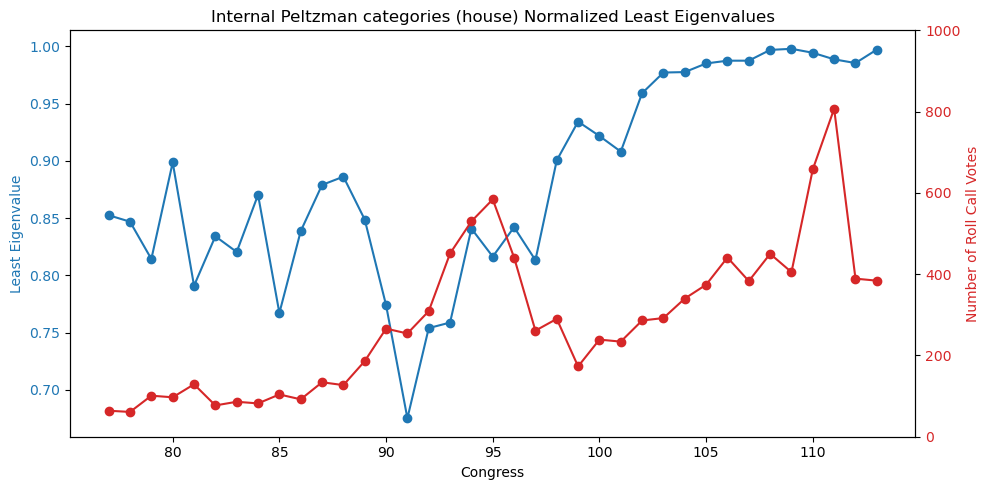

In [11]:
eigenvalues = {}
n_votes_dict = {}  # Dictionary to store the number of votes for each congress

for csv in tqdm(glob.glob(edgelists_path + 'votes_'+chamber+'_peltzman_edges/' + 'internal' + '/*.csv')):
	n_congress = int(os.path.basename(csv).replace('congress_', '').replace('.csv', ''))


	# Rest of your existing code to compute eigenvalues
	temp = pd.read_csv(thresholds_path +chamber+'_peltzman_thresholds/' + 'internal' + '/' + str(n_congress) + '_dic_thresholds_norm.csv')
	threshold_pos = temp.iloc[0]['pos_threshold']
	threshold_neg = temp.iloc[0]['neg_threshold']
	n_votes = temp.iloc[0]['n_votes']  # Read the 'n_votes' column
	n_votes_dict[n_congress] = n_votes  # Store the number of votes

	# Read the CSV file into a pandas DataFrame
	df = pd.read_csv(csv)
	df_pos = df.loc[(df['weight']==1)&(df['perc']>threshold_pos)].copy()
	df_neg = df.loc[(df['weight']==-1)&(df['perc']>threshold_neg)].copy()
	df = pd.concat([df_pos, df_neg])

	# Create a graph from the DataFrame
	G = nx.from_pandas_edgelist(df, 'source', 'target')

	# check if df is empty
	if df.empty:
		continue
	else:
		# Check if the graph is connected
			if not nx.is_connected(G):
			# If the graph is not connected, continue to the next iteration
				continue

	least_eigevalue = read_edgelist_eigen(csv, threshold_pos, threshold_neg)
	eigenvalues[n_congress] = least_eigevalue
	
	
#Plot the eigenvalues on the left y-axis
congress_list = sorted(eigenvalues.keys())
eigenvalue_list = [eigenvalues[x] for x in congress_list]

fig, ax1 = plt.subplots(figsize=(10, 5))

color = 'tab:blue'
ax1.set_xlabel('Congress')
ax1.set_ylabel('Least Eigenvalue', color=color)
ax1.plot(congress_list, eigenvalue_list, 'o-', color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Create a second y-axis
ax2 = ax1.twinx()

n_votes_list = [n_votes_dict[x] for x in congress_list]
color = 'tab:red'
ax2.set_ylabel('Number of Roll Call Votes', color=color)
ax2.plot(congress_list, n_votes_list, 'o-', color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim([0, 1000])

ouput = '../plots/norm_least_eigenvalues/'+chamber+'_peltzman/internal_nle.png'

# set title
plt.title('Internal Peltzman categories ('+chamber+') Normalized Least Eigenvalues')

fig.tight_layout()
plt.savefig(ouput)

100%|██████████| 37/37 [00:43<00:00,  1.16s/it]


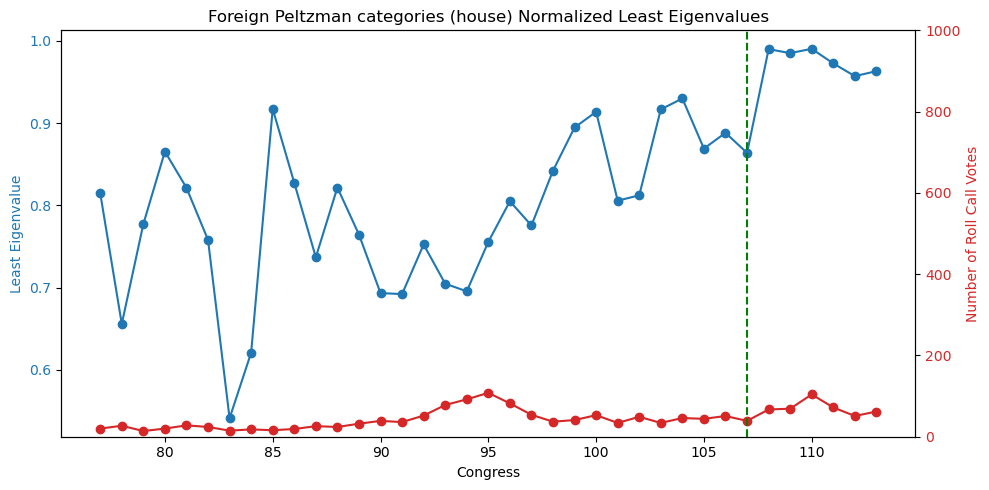

In [14]:
eigenvalues = {}
n_votes_dict = {}  # Dictionary to store the number of votes for each congress

for csv in tqdm(glob.glob(edgelists_path + 'votes_'+chamber+'_peltzman_edges/' + 'foreign' + '/*.csv')):
	n_congress = int(os.path.basename(csv).replace('congress_', '').replace('.csv', ''))


	# Rest of your existing code to compute eigenvalues
	temp = pd.read_csv(thresholds_path +chamber+'_peltzman_thresholds/' + 'foreign' + '/' + str(n_congress) + '_dic_thresholds_norm.csv')
	threshold_pos = temp.iloc[0]['pos_threshold']
	threshold_neg = temp.iloc[0]['neg_threshold']
	n_votes = temp.iloc[0]['n_votes']  # Read the 'n_votes' column
	n_votes_dict[n_congress] = n_votes  # Store the number of votes

	# Read the CSV file into a pandas DataFrame
	df = pd.read_csv(csv)
	df_pos = df.loc[(df['weight']==1)&(df['perc']>threshold_pos)].copy()
	df_neg = df.loc[(df['weight']==-1)&(df['perc']>threshold_neg)].copy()
	df = pd.concat([df_pos, df_neg])

	# Create a graph from the DataFrame
	G = nx.from_pandas_edgelist(df, 'source', 'target')

	# check if df is empty
	if df.empty:
		continue
	else:
		# Check if the graph is connected
			if not nx.is_connected(G):
			# If the graph is not connected, continue to the next iteration
				continue

	least_eigevalue = read_edgelist_eigen(csv, threshold_pos, threshold_neg)
	eigenvalues[n_congress] = least_eigevalue
	
	
#Plot the eigenvalues on the left y-axis
congress_list = sorted(eigenvalues.keys())
eigenvalue_list = [eigenvalues[x] for x in congress_list]

fig, ax1 = plt.subplots(figsize=(10, 5))

color = 'tab:blue'
ax1.set_xlabel('Congress')
ax1.set_ylabel('Least Eigenvalue', color=color)
ax1.plot(congress_list, eigenvalue_list, 'o-', color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Create a second y-axis
ax2 = ax1.twinx()

n_votes_list = [n_votes_dict[x] for x in congress_list]
color = 'tab:red'
ax2.set_ylabel('Number of Roll Call Votes', color=color)
ax2.plot(congress_list, n_votes_list, 'o-', color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim([0, 1000])

#add a vertical line at the 107th congress
plt.axvline(x=107, color='g', linestyle='--')

ouput = '../plots/norm_least_eigenvalues/'+chamber+'_peltzman/foreign_nle.png'

# set title
plt.title('Foreign Peltzman categories ('+chamber+') Normalized Least Eigenvalues')

fig.tight_layout()
plt.savefig(ouput)

______________________________________________

What happened in the 107th congress?

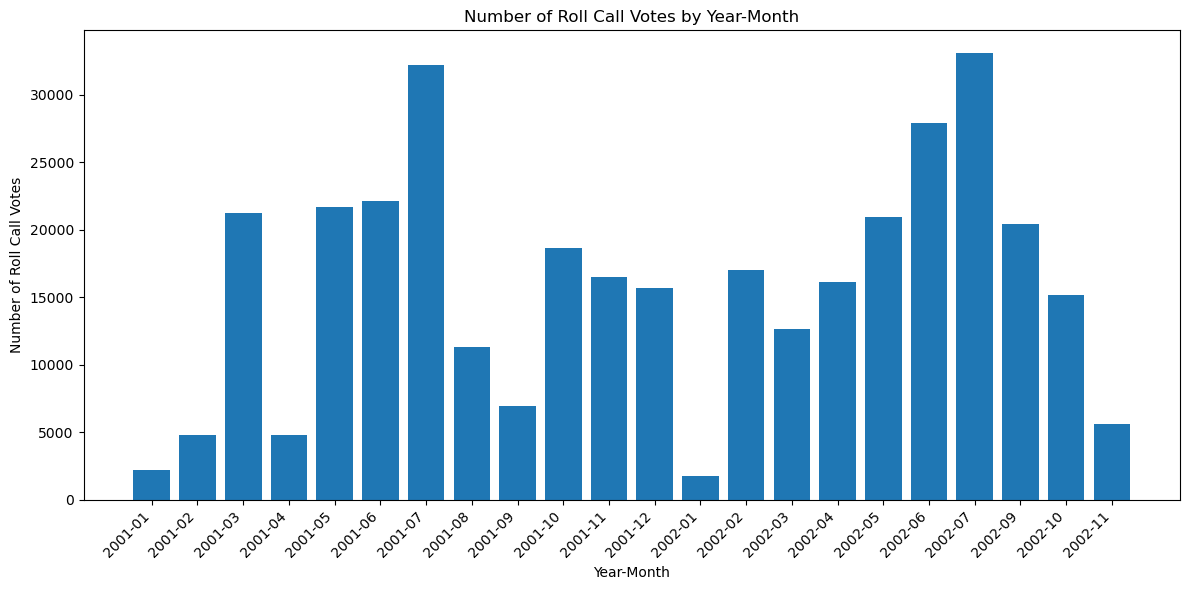

In [27]:
# Load the CSV file into a pandas DataFrame
x107th_cong = '../dataset/votes_house_peltzman/internal/congress_107.csv'
df = pd.read_csv(x107th_cong)

# Convert the 'Date' column to a pandas datetime object
df['date'] = pd.to_datetime(df['date'])

# Extract the year and month from the 'Date' column
df['Year'] = df['date'].dt.year
df['Month'] = df['date'].dt.month

# Group the data by year and month and count the number of roll call votes
monthly_votes = df.groupby(['Year', 'Month']).size().reset_index(name='Vote Count')

# Sort the data by year and month
monthly_votes = monthly_votes.sort_values(['Year', 'Month'])

# Create a figure and axis for the histogram
plt.figure(figsize=(12, 6))
plt.bar(range(len(monthly_votes)), monthly_votes['Vote Count'])

# Set the x-axis labels to show year and month
x_labels = [f"{year}-{month:02}" for year, month in zip(monthly_votes['Year'], monthly_votes['Month'])]
plt.xticks(range(len(monthly_votes)), x_labels, rotation=45, ha='right')

# Set axis labels and title
plt.xlabel('Year-Month')
plt.ylabel('Number of Roll Call Votes')
plt.title('Number of Roll Call Votes by Year-Month')

# Show the plot
plt.tight_layout()
plt.show()

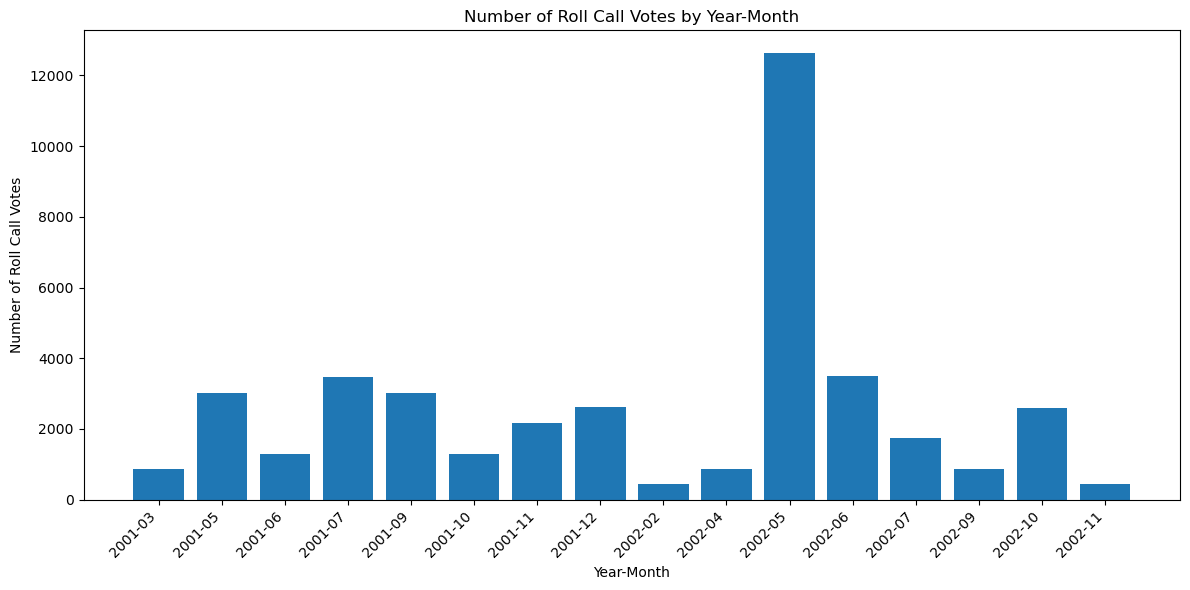

In [28]:
# Load the CSV file into a pandas DataFrame
x107th_cong = '../dataset/votes_house_peltzman/foreign/congress_107.csv'
df = pd.read_csv(x107th_cong)

# Convert the 'Date' column to a pandas datetime object
df['date'] = pd.to_datetime(df['date'])

# Extract the year and month from the 'Date' column
df['Year'] = df['date'].dt.year
df['Month'] = df['date'].dt.month

# Group the data by year and month and count the number of roll call votes
monthly_votes = df.groupby(['Year', 'Month']).size().reset_index(name='Vote Count')

# Sort the data by year and month
monthly_votes = monthly_votes.sort_values(['Year', 'Month'])

# Create a figure and axis for the histogram
plt.figure(figsize=(12, 6))
plt.bar(range(len(monthly_votes)), monthly_votes['Vote Count'])

# Set the x-axis labels to show year and month
x_labels = [f"{year}-{month:02}" for year, month in zip(monthly_votes['Year'], monthly_votes['Month'])]
plt.xticks(range(len(monthly_votes)), x_labels, rotation=45, ha='right')

# Set axis labels and title
plt.xlabel('Year-Month')
plt.ylabel('Number of Roll Call Votes')
plt.title('Number of Roll Call Votes by Year-Month')

# Show the plot
plt.tight_layout()
plt.show()